## Imports

In [1]:
import os
import glob
import datetime
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

2025-03-25 11:11:04.515319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Chemins d'accès

In [ ]:
# Chemins des dossiers contenant les fichiers CSV
base_path = './data/processed'
names = ['Antoine', 'Corentin', 'Felix', 'Leo', 'Vladislav', 'Matthieu', 'Serge']

# Liste pour stocker les données et les étiquettes
train_data = []
train_labels = []

test_data = []
test_labels = []

# LA VARIABLE LA PLUS IMPORTANTE, C'EST LA TAILLE DES SEQUENCES
frame_size = 250

## Préparation des données

In [ ]:
# Fonction pour créer des séquences de données
# Hop_length c'est à dire le pas entre les séquences générées.
# Si tu veux que les séquences se chevauchent, tu peux mettre hop_length < frame_size
# Si tu veux que les séquences soient disjointes, tu peux mettre hop_length = frame_size
def create_frames(data, frame_size=250, hop_length=1):
    frames = []
    for start in range(0, len(data) - frame_size + 1, hop_length):
        frame = data[start:start + frame_size]
        if len(frame) == frame_size:
            frames.append(frame)
    return np.array(frames)

### Création des séquences

In [ ]:
# Charger les données
all_test_files = []
for name in names:
    folder_path = os.path.join(base_path, name)
    all_files = glob.glob(folder_path + '/*.csv')
    # Ça c'est pour savoir quel est ton train test split, ici on prend 5 fichiers au hasard par personne pour le test
    # Donc ça veut dire 50% des données de chaque personne sont pour le test
    test_files = random.sample(all_files, 5)
    all_test_files.extend(test_files)
    for file_path in all_files:
        file_path_no_prefix = os.path.basename(file_path)
        df = pd.read_csv(file_path)
        acc_data = df['acceleration (g)'].values

        # Créer des trames à partir des données d'accélération
        frames = create_frames(acc_data, frame_size=frame_size, hop_length=1)

        # Train test split
        if file_path in test_files:
            for frame in frames:
                test_data.append(frame)
                test_labels.append(name)
        else:
            for frame in frames:
                train_data.append(frame)
                train_labels.append(name)
                
print(all_test_files)

['./data/processed/Antoine/accelerometer1_data.csv', './data/processed/Antoine/accelerometer3_data.csv', './data/processed/Antoine/accelerometer9_data.csv', './data/processed/Antoine/accelerometer4_data.csv', './data/processed/Antoine/accelerometer5_data.csv', './data/processed/Corentin/accelerometer2_data.csv', './data/processed/Corentin/accelerometer9_data.csv', './data/processed/Corentin/accelerometer7_data.csv', './data/processed/Corentin/accelerometer8_data.csv', './data/processed/Corentin/accelerometer1_data.csv', './data/processed/Felix/accelerometer7_data.csv', './data/processed/Felix/accelerometer4_data.csv', './data/processed/Felix/accelerometer10_data.csv', './data/processed/Felix/accelerometer5_data.csv', './data/processed/Felix/accelerometer2_data.csv', './data/processed/Leo/accelerometer9_data.csv', './data/processed/Leo/accelerometer10_data.csv', './data/processed/Leo/accelerometer4_data.csv', './data/processed/Leo/accelerometer7_data.csv', './data/processed/Leo/accelero

In [ ]:
# Convertir en tableaux numpy
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Encoder les prénoms
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_encoded = to_categorical(train_labels_encoded)
test_labels_encoded = to_categorical(test_labels_encoded)

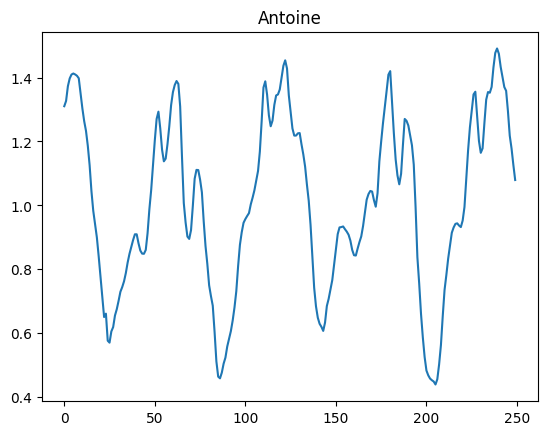

In [20]:
# Pour voir une séquence au pif
def plot_random_frame(data, labels):
    idx = np.random.randint(0, len(data), 1)
    plt.plot(data[idx].flatten())
    plt.title(labels[idx][0])
    plt.show()

plot_random_frame(train_data, train_labels)

In [21]:
print(train_data.shape, train_labels_encoded.shape)
print(test_data.shape, test_labels_encoded.shape)

(22474, 250) (22474, 7)
(23777, 250) (23777, 7)


In [22]:
X_train, X_test, y_train, y_test = train_data.reshape(train_data.shape[0], train_data.shape[1], 1), test_data.reshape(test_data.shape[0], test_data.shape[1], 1), train_labels_encoded, test_labels_encoded

In [ ]:
# Construire le modèle
model = Sequential([
    InputLayer(input_shape=(frame_size, 1)),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=6, strides=6),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(names), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(model.input_shape)

/usr/local/Caskroom/miniconda/base/envs/arduino-streamlit/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 248, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 124, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 122, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 28, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,447 (677.53 KB)

 Trainable params: 173,447 (677.53 KB)

 Non-trainable params: 0 (0.00 B)

(None, 250, 1)


In [24]:

# Entraîner le modèle
history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.1838 - loss: 1.8723 - val_accuracy: 0.4523 - val_loss: 1.4901
Epoch 2/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5493 - loss: 1.1492 - val_accuracy: 0.6735 - val_loss: 1.0060
Epoch 3/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.7928 - loss: 0.6024 - val_accuracy: 0.7575 - val_loss: 0.8777
Epoch 4/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8754 - loss: 0.3701 - val_accuracy: 0.7390 - val_loss: 1.2173
Epoch 5/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9205 - loss: 0.2447 - val_accuracy: 0.7691 - val_loss: 1.1303
Epoch 6/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9400 - loss: 0.1788 - val_accuracy: 0.7898 - val_loss: 0.9806
Epoch 7/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9551 - loss: 0.1402 - val_accuracy: 0.7882 - val_loss: 1.2367
Epoch 8/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9587 - loss: 0.1267 - 

In [25]:
accuracy = history.history['val_accuracy'][-1]
print(accuracy)

0.7981662750244141


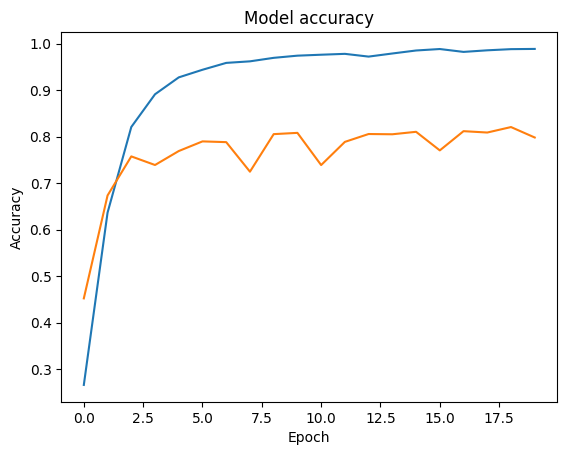

In [26]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)

In [27]:
def save_model(model, name):
    path = f'models/{name}_{accuracy*100:.2f}_{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}'
    os.mkdir(path)
    with open(f'{path}/summary.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    with open(f'{path}/test_files.txt', 'w') as f:
        f.write('\n'.join(all_test_files))
    model.save(f"{path}/model_{frame_size}.keras")
    
#save_model(model, 'cnn_3layers')

744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


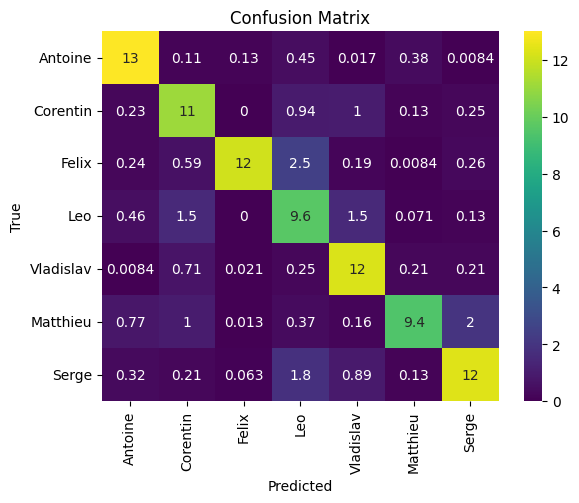

In [28]:
y_pred = model.predict(X_test)

conf = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))/len(y_test) * 100
sns.heatmap(conf, annot=True, xticklabels=names, yticklabels=names, cmap="viridis")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
def predict(df):
    frames = create_frames(df['acceleration (g)'].values, frame_size=frame_size, hop_length=1)
    frames = frames.reshape(frames.shape[0], frames.shape[1], 1)
    print(frames.shape)
    predictions = model.predict(frames)
    predictions_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    #predictions_labels = [names[label] for label in predictions_labels]
    return predictions_labels


test_recording_path = "./data/misc/accelerometer11_data.csv"
df = pd.read_csv(test_recording_path)

predictions = predict(df)

print(predictions)


(1754, 250, 1)
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
['Matthieu' 'Vladislav' 'Vladislav' ... 'Vladislav' 'Vladislav'
 'Vladislav']


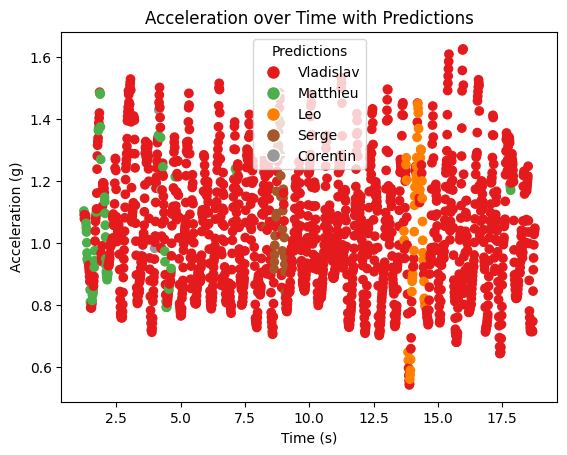

Counter({'Vladislav': 1606,
         'Matthieu': 63,
         'Leo': 53,
         'Serge': 29,
         'Corentin': 3})

In [30]:

def show_predictions(df, predictions):
    n = len(predictions)
    m = len(df)
    # Create a colormap
    c = Counter(predictions)
    mc = c.most_common()
    sorted_list = [x[0] for x in mc]
    unique_predictions = sorted_list
    colors = plt.get_cmap('Set1', len(unique_predictions))
    color_map = {label: colors(i) for i, label in enumerate(unique_predictions)}
    
    # Plot the data with colors based on predictions
    fig, ax = plt.subplots()
    ax.scatter(df['time (s)'][(m-n)//2:n+(m-n)//2], df['acceleration (g)'][(m-n)//2:n+(m-n)//2], c=[color_map[label] for label in predictions])
    
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=10) for label in sorted_list]
    plt.legend(handles, sorted_list, title="Predictions")
    
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    plt.title('Acceleration over Time with Predictions')
    plt.show()
    
    return c

show_predictions(df, predictions)